# Imports

In [1]:
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

DATA_PATH = Path(os.getenv("DATA_PATH"))

# only for .ipynb because relative imports don't work
root_path = (DATA_PATH.parent) 
os.chdir(str(root_path))

import src.training.postprocessing as pp
import src.training.pre_training as t

from sklearn.metrics import precision_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# sklearn ensemble
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

# import models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Data preparation and feature assignment

In [2]:
df_complete = t.get_complete_df()

## Encode all features

In [8]:
df = df_complete.drop(['id', 'name', 'artist_id', 'generation', 'song_id', 'primary_artist_id', 'lyrics_skipped', 'lyrics_stored'], axis=1)
# print(list(df))
# print(df)

# Song popularity
df.iloc[:, 0] = df.iloc[:, 0].apply(t.encode_popularity)

# Artist popularity
df.iloc[:, -2] = df.iloc[:, -2].apply(t.encode_popularity)

# Artist genres
df.iloc[:, -1] = df.iloc[:, -1].apply(t.encode_genres)

# print(df)

# TODO Use RUS or plain data?
df, y = RandomUnderSampler(random_state=42).fit_resample(df.iloc[:, 1:], df.iloc[:, 0])
print(pp.count_distribution(y))

X_dict = dict()
y = df.iloc[:, [0]]

[537, 537, 537, 537, 537]


f:\SmartGit-Repositories\song-popularity\venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Split DataFrame into model types

In [9]:
df_music = pd.DataFrame(df.values[:, 1:16])
X_dict['music'] = df_music
# print(df_music)

df_lyrics = pd.DataFrame(df.values[:, 16:19])
X_dict['lyrics'] = df_lyrics
# print(df_lyrics)

df_artist = df[["followers", "genre_name"]]
X_dict['artist'] = df_artist
# print(df_artist)

# Models

## Add models into classifier list

In [10]:
# TODO use better models: check for equal popularity encoding
lyric_clf = pp.load_model("gauss_prec=31", "lyrics")
artist_clf = pp.load_model("rf_size=100_prec=70", "artist")
music_clf = pp.load_model("rf_size=1000_prec=41", "music")

clf_list = [
    (music_clf, 'music'),
    (lyric_clf, 'lyrics'),
    (artist_clf, 'artist'),
]

# Simulate Voting Classifier

In [17]:
predictions = np.asarray([clf.predict(X_dict[X_type]) for clf, X_type in clf_list])
print(list(predictions))

weights = [1, 1, 1]
# pred_avg = np.average(predictions, axis=0, weights=weights).round()
pred_avg = lyric_clf.predict(X_dict["lyrics"])
print(pred_avg)

print("Weighted accuracy: " + str(round(accuracy_score(y, pred_avg), 4)))
print("Weighted precision: " + str(round(precision_score(y, pred_avg, average="weighted"), 4)))

[array([1, 1, 1, ..., 1, 1, 1], dtype=int64), array([1, 1, 1, ..., 1, 1, 1], dtype=int64), array([5, 5, 5, ..., 5, 5, 5], dtype=int64)]


ValueError: operands could not be broadcast together with shapes (2685,2) (3,) 

# Model Evaluation

## Distribution of predicted class

<BarContainer object of 3 artists>

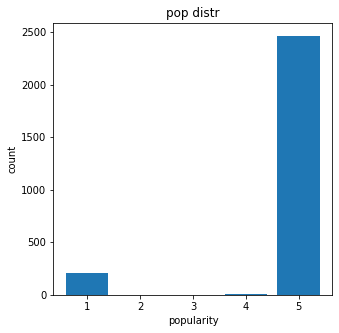

In [16]:
# Plot distr
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_title("pop distr")
ax.set_xlabel("popularity")
ax.set_ylabel("count")

plt.bar(list(set(pred_avg)), pp.count_distribution(pred_avg))